In [1]:
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def voltage_to_x(V):
    
    x = (V - V_min) / (V_max - V_min) * (width - 1)
    x_pixel = int(round(x))
    
    return x_pixel

def y_to_current_density(y_pixel):
    
    i = i_max - (y_pixel / (height - 1)) * (i_max - i_min)
    #unit is A/cm2
    return i

def get_currents_at_voltage(binary_img, V):
    
    x = voltage_to_x(V)
    column = binary_img[:, x]
    y_indices = np.where(column == 0)[0]
    currents_denisty = [y_to_current_density(y) for y in y_indices]
    
    return currents_denisty

def current_density_to_y(i):
    
    y = (i_max - i) / (i_max - i_min) * (height - 1)
    y_pixel = int(round(y))
    
    return y_pixel

def x_to_voltage(x_pixel):
    
    V = V_min + (x_pixel / (width - 1)) * (V_max - V_min)
    return V

def get_voltages_at_current(binary_img, i):
    
    y = current_density_to_y(i)
    row = binary_img[y, :] 
    x_indices = np.where(row == 0)[0]
    voltages = [x_to_voltage(x) for x in x_indices]

    return voltages

def get_k_b_from_two_points(binary_img, V_1, V_2):
    
    i_1 = get_currents_at_voltage(binary_img, V_1)
    i_2 = get_currents_at_voltage(binary_img, V_2)
    k = (i_2[0] - i_1[0]) / (V_2 - V_1)
    b = i_1[0] - k * V_1
    
    return k, b

def get_tafel_slope_from_two_points(binary_img, V_1, V_2):
    
    i_1 = get_currents_at_voltage(binary_img, V_1)
    i_2 = get_currents_at_voltage(binary_img, V_2)
    logi_1 = np.log10(abs(i_1[0]))
    logi_2 = np.log10(abs(i_2[0]))
    k_tafel = (V_2 - V_1) / (logi_2 - logi_1)
    
    return k_tafel

In [37]:
#Load image being convert
image_path = '/Users/chenxinran/Desktop/CV-CNN/MultiviewImageDataset/cv-mixture/1.png'
filename = os.path.splitext(os.path.basename(image_path))[0]
print("filename:", filename)
image = io.imread(image_path)

filename: 1


In [39]:
# Binarization
img_array = np.array(image)
binary_img = np.where(img_array <200 , 0, 255)

In [41]:
# Load experimental details about the CV image being convert
electrode_diameter = 0.3 # cm
electrode_area_cv = 3.14*(electrode_diameter/2)**2 # cm2
width = binary_img.shape[1]
height = binary_img.shape[0]
V_min = -2
V_max = 2
i_min=-500e-6/electrode_area_cv 
i_max=500e-6/electrode_area_cv 
constant_current = 8e-3 # A
electrode_area_work = (1.0*1.5*2 + 1.5*0.6*2 + 1.0*0.6) # 10 mm × 15 mm × 6 mm

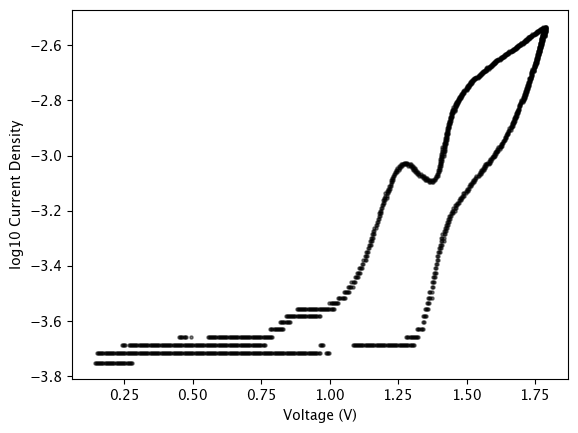

In [43]:
# Convert current density into log(|i|) to determine the tafel region
I_list = []
V_list = []
for i in range(1000):
    for j in range(1000):
        if binary_img[i][j] == 0:
            cur  = y_to_current_density(i)
            cur_log =  np.log10(abs(cur))
            I_list.append(cur_log)
            volt = x_to_voltage(j)
            V_list.append(volt)
            
plt.scatter(V_list, I_list, s=5, alpha=0.5, color = 'black')
plt.xlabel('Voltage (V)')
plt.ylabel('log10 Current Density')
plt.show()

In [45]:
# calculate three electro-descriptors
V_onset1 = 0.2 # observed from the CV, choose onset region
V_onset2 = 0.4 # observed from the CV, choose onset region
k_onset_line, b_onset_line = get_k_b_from_two_points(binary_img, V_onset1, V_onset2)

V_tafel1 = 1.1 # observed from the CV, choose tafel slope region
V_tafel2 = 1.2 # observed from the CV, choose tafel slope region
k_tafel_log = get_tafel_slope_from_two_points(binary_img, V_tafel1, V_tafel2)  # unit V/dec

k_tafel_line, b_tafel_line = get_k_b_from_two_points(binary_img, V_tafel1, V_tafel2)
V_onset = (b_onset_line - b_tafel_line) / (k_tafel_line - k_onset_line) # intersection of the two lines

I_eff_cv = constant_current * electrode_area_cv / electrode_area_work
i_eff_cv = I_eff_cv / electrode_area_cv
V_eff_cv = get_voltages_at_current(binary_img, i_eff_cv)

print("E onset: {}, E effective: {}, Tafel slope: {}".format(V_onset, V_eff_cv[0], k_tafel_log))

E onset: 1.0622222222222233, E effective: 1.4514514514514514, Tafel slope: 0.3685150676181615
